## Дипломная работа

### Прогнозирование продаж фармдистрибьютора

In [196]:
# необходимые библиотеки
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from arch import arch_model

In [197]:
# данные в тыс руб.
df = pd.read_excel("Data.xls")
df.head()

,date,value
0,2019-01-03,515757.63689
1,2019-01-04,513952.19998
2,2019-01-05,3552.93217
3,2019-01-06,26971.21157
4,2019-01-07,0.00000


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    910 non-null    datetime64[ns]
 1   value   910 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.3 KB


In [199]:
# преобразуем и посмотрим статистику 

In [200]:
df.value = round(df.value)
df.value = df.value.astype(np.int32)

In [201]:
df.describe()

,value
count,9.100000e+02
mean,6.506428e+05
std,4.115450e+05
min,0.000000e+00
25%,2.267648e+05
50%,7.358910e+05
75%,9.629105e+05
max,1.661629e+06


In [202]:
# дополнительные функции

In [203]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', title='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(title)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        plt.show()
    return

In [204]:
# посмотрим на тест Дики-Фуллера и графики

In [205]:
series = df.value

Results of Dickey-Fuller Test:
Test Statistic                  -3.967059
p-value                          0.001593
Lags Used                       20.000000
Number of Observations Used    889.000000
Critical Value (1%)             -3.437727
Critical Value (5%)             -2.864797
Critical Value (10%)            -2.568504
dtype: float64


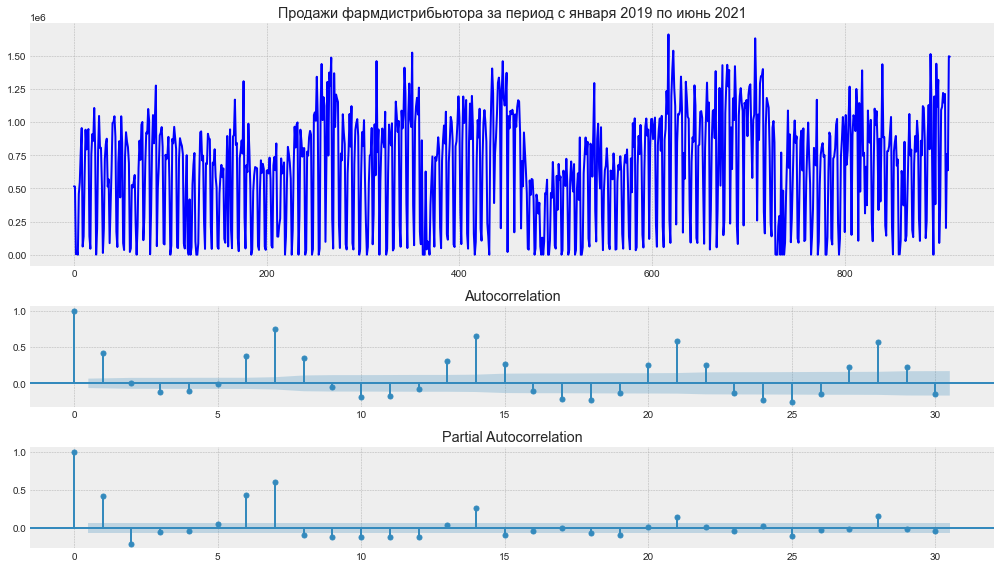

In [206]:
tsplot(series, title="Продажи фармдистрибьютора за период с января 2019 по июнь 2021")

In [207]:
# p-value отвергает гипотезу о нестационарности ряда. Ряд стационарен
# На графике нет сезонности, нет тренда, цикличности тоже нет. 
# Если бы был тренд мы бы его убрали дифференцированием, например series = series[1:] - series[:-1]
# Если бы была сильная дисперсия мы бы нормализовали ее при помощи преобразования Бокса-Кокса, например  boxcox(series, 0)

In [208]:
# Модель LinearRegression

In [209]:
# функция раскладывает временной ряд на признаки, формирует новый датасет и делит на тренеровочные и тестовые данные
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.value.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["date"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["value"], axis=1)
    y_train = data.loc[:test_index]["value"]
    X_test = data.loc[test_index:].drop(["value"], axis=1)
    y_test = data.loc[test_index:]["value"]
    
    return X_train, X_test, y_train, y_test

In [210]:
X_train, X_test, y_train, y_test = prepareData(df, lag_start=5, lag_end=20, test_size=0.2)

In [211]:
from sklearn.linear_model import LinearRegression

In [212]:
# обучим модель линейной регрессии
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

In [213]:
# посчитаем метрики качества предсказания
print(f'RMSE: {(np.sqrt(mean_squared_error(y_test, prediction))):.0f}')

RMSE: 264638


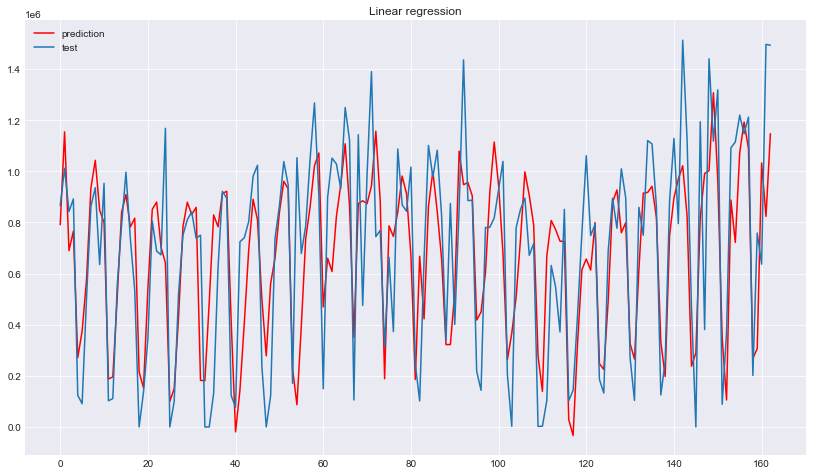

In [214]:
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="test")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

In [215]:
# ARIMA

In [216]:
# функция подбирает оптимальные значения p,d,q для модели ARIMA по критерию Акаике

# по дефолту определяются параметры: акаике, параметры p,d,q, модель ARIAM
best_aic = np.inf 
best_order = None
best_mdl = None

# цикл перебирает параметры p,d,q, которые руками задаются в range каждого цикла
for i in range(7):
    for d in range(3):
        for j in range(7):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                # если критерий акаике наименьший, по нему фиксируются параметры p,d,q и строится модель
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 25138.93520 | order: (5, 1, 5)


In [217]:
# параметры которые описывают ряд (5, 1, 5)
# теперь сделаем предсказание на тесте и оценим качество

In [218]:
len(series)

910

In [219]:
# разделим на тренировочные и тестовые данные
train_series = series[:880]
test_series = series[880:]

In [220]:
# строим модель на тренировочных данных, и передаем подобрынные ранее параметры 
model = smt.ARIMA(train_series, order=(5, 1, 5)).fit(method='mle', trend='nc')

In [221]:
len(test_series)

30

In [222]:
# предсказываем 30 значений
pred = model.forecast(steps=30)[0]

In [223]:
# посчитаем метрики качества предсказания
print(f'RMSE: {(np.sqrt(mean_squared_error(test_series, pred))):.0f}')

RMSE: 336285


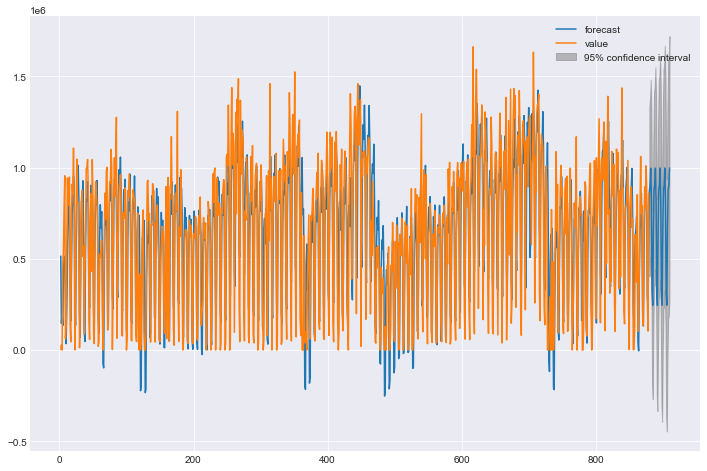

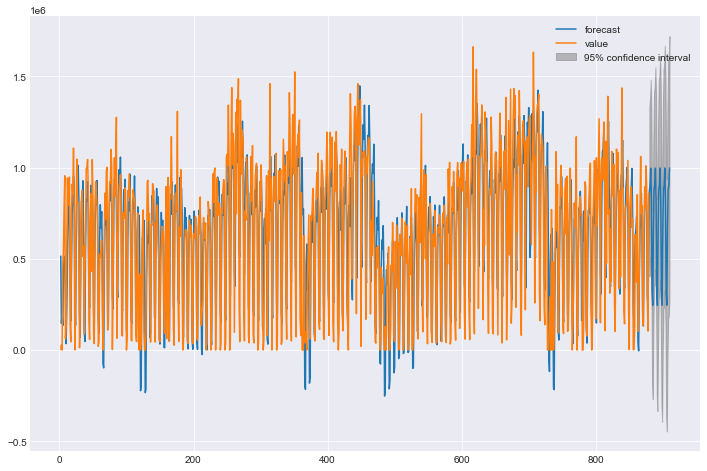

In [224]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.style.use('seaborn-darkgrid')
model.plot_predict(2, len(train_series)+30, ax=ax) 

In [225]:
# LSTM

In [226]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [227]:
dataset = pd.read_excel("Data.xls", usecols=[1])

In [228]:
# нормализуем данные с помощью функции MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [229]:
# разделим данные на тестовые и тренинровочные
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print('Тренировочная выборка:',len(train), 'Тестовая выборка:', len(test))

Тренировочная выборка: 728 Тестовая выборка: 182


In [230]:
# преобразуем массив значений в матрицу данных 
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [231]:
# изменим X=t и Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [232]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [233]:
# создадим и обучим модель LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
726/726 - 1s - loss: 0.0665
Epoch 2/100
726/726 - 0s - loss: 0.0513
Epoch 3/100
726/726 - 0s - loss: 0.0508
Epoch 4/100
726/726 - 0s - loss: 0.0510
Epoch 5/100
726/726 - 0s - loss: 0.0508
Epoch 6/100
726/726 - 0s - loss: 0.0507
Epoch 7/100
726/726 - 0s - loss: 0.0506
Epoch 8/100
726/726 - 0s - loss: 0.0506
Epoch 9/100
726/726 - 0s - loss: 0.0506
Epoch 10/100
726/726 - 0s - loss: 0.0507
Epoch 11/100
726/726 - 0s - loss: 0.0507
Epoch 12/100
726/726 - 0s - loss: 0.0508
Epoch 13/100
726/726 - 0s - loss: 0.0507
Epoch 14/100
726/726 - 0s - loss: 0.0507
Epoch 15/100
726/726 - 0s - loss: 0.0509
Epoch 16/100
726/726 - 0s - loss: 0.0508
Epoch 17/100
726/726 - 0s - loss: 0.0507
Epoch 18/100
726/726 - 0s - loss: 0.0506
Epoch 19/100
726/726 - 0s - loss: 0.0508
Epoch 20/100
726/726 - 0s - loss: 0.0508
Epoch 21/100
726/726 - 0s - loss: 0.0507
Epoch 22/100
726/726 - 0s - loss: 0.0504
Epoch 23/100
726/726 - 0s - loss: 0.0505
Epoch 24/100
726/726 - 0s - loss: 0.0507
Epoch 25/100
726/726 - 0s

In [234]:
# предсказания
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# инвертируем предсказания
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# посчитаем метрику качества
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 372576.20 RMSE
Test Score: 376501.87 RMSE


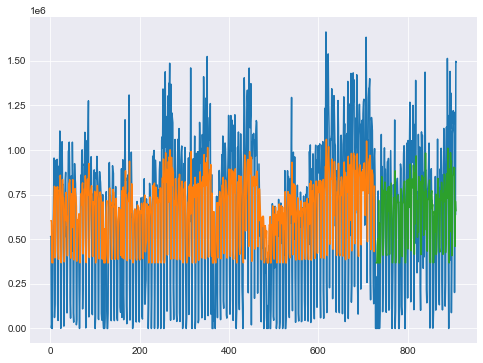

In [235]:
# покажем на графике полученные результаты
plt.figure(figsize=(8, 6))
 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()